In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import sklearn
import random
from tqdm import tqdm
import numpy as np

from skimage import color
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [2]:
def plot_img_with_boxes(img, boxes):
    fig, ax = plt.subplots()
    ax.imshow(img)
    for box in boxes:
        rect = patches.Rectangle(*box, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

def img_with_boxes(img, boxes, linewidth=2, linecolour=(255,0,0)):
    out = img.copy()
    for box in boxes:
        cv.rectangle(out, box[0], (box[0][0] + box[1], box[0][1] + box[2]), linecolour, linewidth)
    return out

def write_img_with_boxes(filename, img, boxes, linewidth=1, linecolour=(0,255,0)):
    img = img_with_boxes(img, boxes, linewidth, linecolour)
    cv.imwrite(filename, cv.cvtColor(img, cv.COLOR_RGB2BGR))

# Read in data

In [71]:
RELOAD_TRAINING = True
RELOAD_SUPP = True

def bbox_trbl_to_xyHeightWidth(bb):
    # translate bounding box from top, right, bottom, left format to xy, height, width format
    return (int(bb["left"]), int(bb["top"])), int(bb["right"]) - int(bb["left"]), int(bb["bottom"]) - int(bb["top"])

if RELOAD_TRAINING:
    step = 1
    print('reloading training data', flush=True)
    path = './benchmark_velocity_train/clips/'
    trg_imgs = {}
    for i in tqdm(range(0, 1074, step)):
        obj = {}
        gt = json.load(open(path + str(i + 1) + "/annotation.json"))
        obj["annotations"] = gt
        bbs = []
        for car in gt:
            bbs.append(bbox_trbl_to_xyHeightWidth(car["bbox"]))
        obj["bboxes"] = bbs
        img = cv.imread(path + str(i + 1) + "/imgs/040.jpg")
        obj["img"] = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        trg_imgs[i+1] = obj

if RELOAD_SUPP:
    step = 5
    print('\n\nreloading supplementary data', flush=True)
    supp_path = './benchmark_velocity_supp/'
    supp_imgs = {}
    gts = dict((x["file_name"], x) for x in json.load(open(supp_path + "annotation.json")))
    for i in tqdm(range(0, 5066, step)):
        obj = {}
        img_file = f"supp_img/{i+1:04d}.jpg"
        bbs = []
        for box in gts[img_file]["bbox"]:
            bbs.append(bbox_trbl_to_xyHeightWidth(box))
        obj["bboxes"] = bbs
    
        img = cv.imread(supp_path + img_file)
        obj["img"] = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        supp_imgs[i+1] = obj

all_imgs = list(supp_imgs.values()) + list(trg_imgs.values())

reloading training data
100%|██████████| 1074/1074 [00:36<00:00, 29.47it/s]

reloading supplementary data

100%|██████████| 1014/1014 [00:47<00:00, 21.43it/s]


### Visualising data

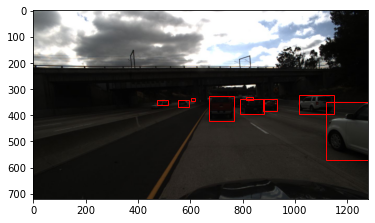

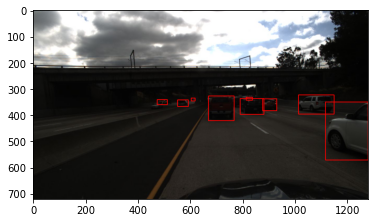

In [20]:
img_to_display = supp_imgs[11]
plot_img_with_boxes(img_to_display["img"], img_to_display["bboxes"])
plt.imshow(img_with_boxes(img_to_display["img"], img_to_display["bboxes"]))
plt.show()
write_img_with_boxes('testout.jpg', img_to_display["img"], img_to_display["bboxes"])

# Generate negative samples

In [72]:

def overlap(bb1, bb2):
    boxes = [bb1, bb2]
    leftmost = 0 if bb1[0][0] < bb2[0][0] else 1
    topmost = 0 if bb1[0][1] < bb2[0][1] else 1
    return boxes[leftmost][0][0] + boxes[leftmost][1] > boxes[leftmost - 1][0][0] and boxes[topmost][0][1] + boxes[topmost][2] > boxes[topmost - 1][0][1]

# use supplementary images, because they seem to have less unlabeled cars
# generate ratio times as many negative samples as positive
ratio = 30
random.seed(5122473)
print("generating negative samples", flush=True)
for obj in tqdm(all_imgs):
    obj["neg_bboxes"] = []
    bbs = obj["bboxes"]
    for bb in bbs:
        # to keep same distribution of sizes, generate new bbs with same size as existing ones
        location = (random.randrange(img.shape[0]), random.randrange(img.shape[1]))
        for i in range(ratio):
            location = (random.randrange(img.shape[1] - bb[1]), random.randrange(img.shape[0] - bb[2]))
            new_bb = (location, bb[1], bb[2])
            count = 0
            while any(overlap(old_bb, new_bb) for old_bb in bbs) and count < 30:
                location = (random.randrange(img.shape[1] - bb[1]), random.randrange(img.shape[0] - bb[2]))
                new_bb = (location, bb[1], bb[2])
                count += 1
            if count == 30:
                pass
                #print(f"exceeded attempts to find location for bbox of size {bb[1]} x {bb[2]}")
            else:
                obj["neg_bboxes"].append(new_bb)


generating negative samples
100%|██████████| 2088/2088 [00:06<00:00, 316.18it/s] 


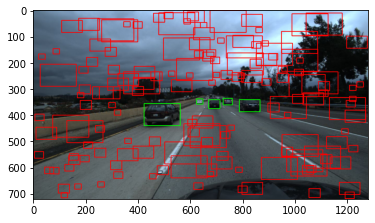

True

In [69]:
img_to_display = supp_imgs[1]
with_neg = img_with_boxes(img_to_display["img"], img_to_display["neg_bboxes"])
with_both = img_with_boxes(with_neg, img_to_display["bboxes"], linecolour=(0,255,0))
plt.imshow(with_both)
plt.show()
with_both = cv.cvtColor(with_both, cv.COLOR_RGB2BGR)
cv.imwrite('supp_neg.jpg', with_both)

# Data Preparation (for classifier)

In [73]:
def enlarge_box(box, factor):
    wDelta = round(box[1]*factor)
    vDelta = round(box[2]*factor)
    left = box[0][0] - wDelta//2
    width = box[1] + wDelta
    top = box[0][1] - vDelta//2
    height = box[2] + vDelta
    return (left, top), width, height

def extract_box(box, img, debug=False):
    (left, top), width, height = box
    right = left + width
    bottom = top + height
    if debug:
        print('tblr', top, bottom, left, right)
    return img[max(top, 0):min(bottom, img.shape[0]),max(left, 0):min(right, img.shape[1])]

positive_samples = []
negative_samples = []
print("extracting image samples", flush=True)
# widen the each dimension of the bounding boxes by this factor before extracting the sample
enlarge_factor = 0.4
pos_locs = []
neg_locs = []
for obj in tqdm(supp_imgs.values()):
    img = obj["img"]
    positive_bboxes = obj["bboxes"]
    negative_bboxes = obj["neg_bboxes"]
    for box in positive_bboxes:
        if (box[1] == 0 or box[2] == 0):
            continue
        sample = extract_box(enlarge_box(box, enlarge_factor), img)
        positive_samples.append(sample)
        pos_locs.append(box[0])
    for box in negative_bboxes:
        if (box[1] == 0 or box[2] == 0):
            continue
        sample = extract_box(enlarge_box(box, enlarge_factor), img)
        negative_samples.append(sample)
        neg_locs.append(box[0])

extracting image samples
100%|██████████| 1014/1014 [00:01<00:00, 594.10it/s]


In [74]:
def resize_images(imgs):
    out = []
    print('resizing', flush=True)
    for img in tqdm(imgs):
        out.append(cv.resize(img, (40, 30)))
    return out
pos_resized = resize_images(positive_samples)
neg_resized = resize_images(negative_samples)

resizing
100%|██████████| 5873/5873 [00:00<00:00, 27593.64it/s]resizing

100%|██████████| 175299/175299 [00:07<00:00, 23761.32it/s]


# Data Augmentation - skip this so feature extraction is < 1 hour lol

In [6]:
def random_crop(img, reduce_factor):
    """ Returns a random crop"""
    r, c,*_ = img.shape
    height = round(r * reduce_factor)
    width = round(c * reduce_factor)

    start_r = random.randrange(r - height)
    start_c = random.randrange(c - width)

    return img[start_r : start_r + height, start_c : start_c + width]

def rotate_cv(im, deg, y=False, mode=cv.BORDER_REFLECT, interpolation=cv.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv.warpAffine(im,M,(c,r), borderMode=mode, flags=cv.WARP_FILL_OUTLIERS+interpolation)

random.seed(5122476)
def augment(imgs):
    rotated = []
    print("radom rotating imgs", flush=True)
    for img in tqdm(imgs):
        rotated.append(img)
        for i in range(3):
            rdeg = (np.random.random()-.50)*20
            rotated.append(rotate_cv(img, rdeg))
    flipped = []
    print("\nflipping images", flush=True)
    for img in tqdm(rotated):
        flipped.append(img)
        flipped.append(np.fliplr(img).copy())
    cropped = []
    print("\nrandom cropping images", flush=True)
    for img in tqdm(flipped):
        for i in range(3):
            cropped.append(random_crop(img, 0.7))
    return flipped

big_pos = augment(pos_resized)
big_neg = augment(neg_resized)

radom rotating imgs
100%|██████████| 3052/3052 [00:00<00:00, 15149.45it/s]
flipping images

100%|██████████| 9156/9156 [00:00<00:00, 67502.85it/s]
random cropping images

100%|██████████| 18312/18312 [00:00<00:00, 96880.76it/s]radom rotating imgs

100%|██████████| 3038/3038 [00:00<00:00, 11199.00it/s]
flipping images

100%|██████████| 9114/9114 [00:00<00:00, 50488.46it/s]
random cropping images

100%|██████████| 18228/18228 [00:00<00:00, 71673.58it/s]


# Feature Extraction

In [75]:
def colour_hist(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    r_hist, _ = np.histogram(r.ravel(), bins=10)
    g_hist, _ = np.histogram(g.ravel(), bins=10)
    b_hist, _ = np.histogram(b.ravel(), bins=10)
    return np.concatenate((r_hist, g_hist, b_hist))

winSize = (40,30)
blockSize = (20,20)
blockStride = (10,10)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True

hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)
ppc = 16
hog_images = []
hog_features = []
locations = []
colour_hists = []
labels = []
print("computing features for positive", flush=True)
count = 0
for image in tqdm(pos_resized):
    #image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    fd = hog.compute(image)
    hog_features.append(fd[:,0])
    # locations.append(pos_locs[count])
    # colour_hists.append(colour_hist(image))
    count += 1
    labels.append(1)
print("\ncomputing features for negative", flush=True)
count = 0
for image in tqdm(neg_resized):
    #image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    fd = hog.compute(image)
    hog_features.append(fd[:,0])
    # locations.append(neg_locs[count])
    # colour_hists.append(colour_hist(image))
    count += 1
    labels.append(0)

computing features for positive
100%|██████████| 5873/5873 [00:00<00:00, 7359.99it/s]
computing features for negative

100%|██████████| 175299/175299 [00:28<00:00, 6192.20it/s]


# Train classification model

In [76]:
labels =  np.array(labels).reshape(len(labels),1)

clf = svm.SVC()
hog_features = np.array(hog_features)
locations = np.array(locations)
data_frame = np.hstack((hog_features,labels))
np.random.shuffle(data_frame)

percentage = 85
partition = int(len(hog_features)*percentage/100)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

print("train examples:", len(x_train), flush=True)
clf.fit(x_train,y_train)

print("training complete")
print("test examples:", len(x_test), flush=True)
y_pred = clf.predict(x_test)
print("done", flush=True)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

train examples: 153996
training complete
test examples: 27176
done
Accuracy: 0.9915366499852811


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     26284
         1.0       0.96      0.77      0.86       892

    accuracy                           0.99     27176
   macro avg       0.98      0.88      0.93     27176
weighted avg       0.99      0.99      0.99     27176


[[26259    25]
 [  205   687]]


# Perform sliding window identification on images


window of size 80 x 60
100%|██████████| 40/40 [00:05<00:00,  7.48it/s]
9 matches

window of size 120 x 90

100%|██████████| 27/27 [00:02<00:00, 11.12it/s]
3 matches

window of size 180 x 135

100%|██████████| 18/18 [00:01<00:00, 16.63it/s]
2 matches

window of size 270 x 202

100%|██████████| 12/12 [00:00<00:00, 23.65it/s]

1 matches


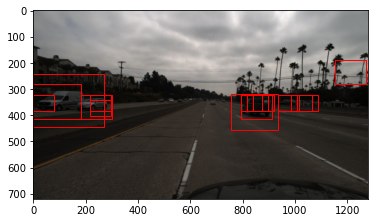

In [86]:
def slide_window(img, window_shape, step, eval_func):
    matches = []
    print(f"\nwindow of size {window_shape[0]} x {window_shape[1]}", flush=True)
    for start_row in tqdm(range(0, img.shape[0], step[1])):
        for start_col in range(0, img.shape[1], step[0]):
            extract = img[start_row : start_row + window_shape[1], start_col : start_col + window_shape[0]]
            try:
                if eval_func(extract, (start_col, start_row)):
                    matches.append((start_col, start_row))
            except:
                print(extract)
                print(window_shape)
                print(img.shape)
                print(start_row, start_row + window_shape[1], start_col, start_col + window_shape[0])
                raise Exception
    print(f"\n{len(matches)} matches")
    return matches

def multi_level_detect(img, min_window, max_window_width, factor, step_ratio, eval_func):
    window = np.array(min_window)
    boxes = []
    while window[0] <= max_window_width:
        step = np.rint(window * step_ratio).astype(int)
        matches = slide_window(img, window, step, eval_func)
        boxes += [(location, *window) for location in matches]
        window = np.rint(window * factor).astype(int)
    return boxes

def my_eval(img, loc):
    resized = cv.resize(img, (40, 30))
    #gray = cv.cvtColor(resized, cv.COLOR_RGB2GRAY)
    return clf.predict([list(hog.compute(resized)[:,0])])[0] > 0.5

inp_file = "./benchmark_velocity_test/clips/8/imgs/040.jpg"
image = cv.imread(inp_file)
rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
boxes = multi_level_detect(rgb, (80, 60), 400, 1.5, 0.3, my_eval)
plot_img_with_boxes(rgb, boxes)
write_img_with_boxes('new_results/' + inp_file.replace("/", "_"), rgb, boxes)

# Test mean minimum distance to correct box

In [84]:
def mean_min_box_distance(correct_boxes, predicted_boxes):
    correct_centres = [(b[0][0] + b[1]/2, b[0][1] + b[2]/2) for b in correct_boxes]
    predicted_centres = [(b[0][0] + b[1]/2, b[0][1] + b[2]/2) for b in predicted_boxes]

    sum_mins = 0
    for centre in predicted_centres:
        sum_mins += min(((c[0] - centre[0]) ** 2 + (c[1] - centre[1]) ** 2) ** 0.5 for c in correct_centres)
    if len(predicted_boxes) == 0 and len(correct_boxes) != 0:
        return 99999999
    elif len(predicted_boxes) == 0:
        return 0
    return sum_mins / len(predicted_boxes)

step = 5
print('\n\nreloading supplementary data', flush=True)
supp_path = './benchmark_velocity_supp/'
supp_imgs = {}
gts = dict((x["file_name"], x) for x in json.load(open(supp_path + "annotation.json")))
means = []
for i in tqdm(range(1, 40, step)):
    img_file = f"supp_img/{i+1:04d}.jpg"
    correct_bbs = []
    for box in gts[img_file]["bbox"]:
        correct_bbs.append(bbox_trbl_to_xyHeightWidth(box))

    img = cv.imread(supp_path + img_file)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    boxes = multi_level_detect(rgb, (80, 60), 400, 1.5, 0.3, my_eval)
    mean = mean_min_box_distance(correct_bbs, boxes)
    #print(f"\n mean for img {i+1}", mean_min_box_squared_distance(correct_bbs, boxes))
    means.append(mean)
print()
print("\nall means", means)


e 80 x 60

100%|██████████| 40/40 [00:05<00:00,  6.80it/s]
3 matches

window of size 120 x 90


100%|██████████| 27/27 [00:02<00:00, 10.96it/s]
1 matches

window of size 180 x 135


100%|██████████| 18/18 [00:01<00:00, 14.09it/s]
0 matches

window of size 270 x 202


 50%|█████     | 4/8 [00:40<00:40, 10.10s/it]
0 matches

window of size 80 x 60

100%|██████████| 40/40 [00:06<00:00,  6.45it/s]
6 matches

window of size 120 x 90


100%|██████████| 27/27 [00:02<00:00,  9.39it/s]
2 matches

window of size 180 x 135


100%|██████████| 18/18 [00:01<00:00, 14.40it/s]
1 matches

window of size 270 x 202


 62%|██████▎   | 5/8 [00:51<00:31, 10.44s/it]
0 matches

window of size 80 x 60

100%|██████████| 40/40 [00:06<00:00,  6.47it/s]
6 matches

window of size 120 x 90


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]
3 matches

window of size 180 x 135


100%|██████████| 18/18 [00:01<00:00, 13.88it/s]
0 matches

window of size 270 x 202


 75%|███████▌  | 6/8 [01:02<00:21, 10.67s/it]
0 matches


# Non-Maximum Suppression

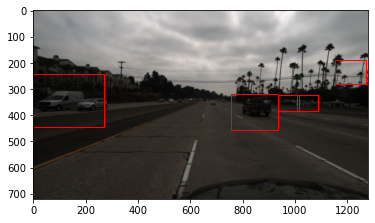

In [87]:
# Below was found at https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")
boxes_tl_br = np.array([(box[0][0], box[0][1], box[0][0] + box[1], box[0][1] + box[2]) for box in boxes])
suppressed_boxes = non_max_suppression_fast(boxes_tl_br, 0.4)
suppressed_xy_width_height = [((box[0], box[1]), box[2] - box[0], box[3] - box[1]) for box in suppressed_boxes]
plot_img_with_boxes(rgb, suppressed_xy_width_height)
write_img_with_boxes('suppressed_results/' + inp_file.replace("/", "_"), rgb, suppressed_xy_width_height)